In [8]:
# STEP 1: Import Libraries
# ------------------------
# Import all necessary libraries for data manipulation, visualization, and modeling.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score


In [9]:
import pandas as pd
dataset_url= "https://raw.githubusercontent.com/tabrezdn1/olympics-medal-prediction/refs/heads/main/olympics_dataset.csv"
df = pd.read_csv(dataset_url)

# Examine the first few rows
print("First 5 rows of the dataset:")
print(df.head())

# Display information about the dataset, including columns, dtypes, and missing values.
print("\nDataset Info:")
df.info()


First 5 rows of the dataset:
   player_id                   Name Sex            Team  NOC  Year  Season  \
0          0              A Dijiang   M           China  CHN  1992  Summer   
1          1               A Lamusi   M           China  CHN  2012  Summer   
2          2            Gunnar Aaby   M         Denmark  DEN  1920  Summer   
3          3            Edgar Aabye   M  Denmark/Sweden  DEN  1900  Summer   
4         26  Cornelia (-strannood)   F     Netherlands  NED  1932  Summer   

          City       Sport                         Event     Medal  
0    Barcelona  Basketball   Basketball Men's Basketball  No medal  
1       London        Judo  Judo Men's Extra-Lightweight  No medal  
2    Antwerpen    Football       Football Men's Football  No medal  
3        Paris  Tug-Of-War   Tug-Of-War Men's Tug-Of-War      Gold  
4  Los Angeles   Athletics  Athletics Women's 100 metres  No medal  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252565 entries, 0 to 25

In [11]:
# STEP 3: Data Cleaning and Preprocessing
# ---------------------------------------
# We will:
# 1. Check and drop missing values if negligible.
# 2. Aggregate data at the Team-Year level (treating Team as "country" equivalent).
# 3. Encode categorical features.
# 4. Scale numeric features.
# 5. Split into training, validation, and test sets.

# Drop rows with missing values for simplicity
df.dropna(inplace=True)

# We need to count only rows where a medal (Gold, Silver, Bronze) was won.
# 'No medal' indicates no medal was awarded. Let's define a function for counting medals:
def count_medals(series):
    return sum(series.isin(['Gold', 'Silver', 'Bronze']))

# Aggregate the data at the (Team, Year) level
# - MedalCount: count how many rows have a Gold/Silver/Bronze medal
# - NumSports: number of unique sports participated in by that team that year
# - NumEvents: number of unique events participated in
# - NumAthletes: number of unique athletes (Name)
country_year_group = df.groupby(['Team', 'Year']).agg({
    'Medal': count_medals,
    'Sport': 'nunique',
    'Event': 'nunique',
    'Name': 'nunique'
}).reset_index()

# Rename columns to maintain consistency
country_year_group.rename(columns={'Medal': 'MedalCount',
                                   'Sport': 'NumSports',
                                   'Event': 'NumEvents',
                                   'Name': 'NumAthletes'},
                          inplace=True)

# Encode the 'Team' column using one-hot encoding to handle categorical data.
team_encoded = pd.get_dummies(country_year_group['Team'], prefix='Team')

# Combine encoded teams back into the dataframe
data = pd.concat([country_year_group.drop('Team', axis=1), team_encoded], axis=1)

# Define numeric features that need scaling
numeric_feats = ['Year', 'NumSports', 'NumEvents', 'NumAthletes']

# Scale numeric features using StandardScaler for better model performance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data[numeric_feats] = scaler.fit_transform(data[numeric_feats])

# Separate features (X) and target (y)
X = data.drop('MedalCount', axis=1)
y = data['MedalCount']

# Split data into train, validation, and test sets
# Train: 70%, Validation: 15%, Test: 15%
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("\nData Splits:")
print("Train size:", X_train.shape, y_train.shape)
print("Validation size:", X_val.shape, y_val.shape)
print("Test size:", X_test.shape, y_test.shape)


Data Splits:
Train size: (3168, 1197) (3168,)
Validation size: (679, 1197) (679,)
Test size: (679, 1197) (679,)


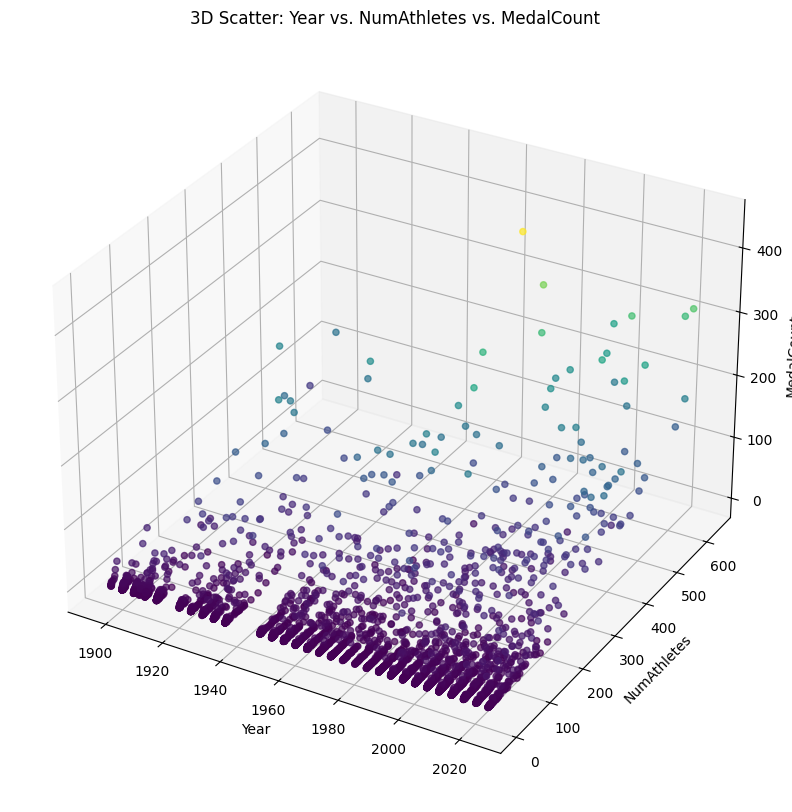

In [13]:
# STEP 4: Exploratory 3D Plot
# ---------------------------
# Let's plot Year vs. NumAthletes vs. MedalCount before modeling to understand the data.
# We'll use the unscaled data from country_year_group for clarity.

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(country_year_group['Year'],
           country_year_group['NumAthletes'],
           country_year_group['MedalCount'],
           c=country_year_group['MedalCount'], cmap='viridis', alpha=0.7)

ax.set_xlabel('Year')
ax.set_ylabel('NumAthletes')
ax.set_zlabel('MedalCount')
ax.set_title('3D Scatter: Year vs. NumAthletes vs. MedalCount')
plt.show()


In [14]:
# STEP 5: Train Linear Regression Model
# -------------------------------------
lr = LinearRegression()
lr.fit(X_train, y_train)

# Validate on validation set
y_val_pred_lr = lr.predict(X_val)
val_r2_lr = r2_score(y_val, y_val_pred_lr)
print("Linear Regression Validation R2:", val_r2_lr)

# Test on test set
y_test_pred_lr = lr.predict(X_test)
test_r2_lr = r2_score(y_test, y_test_pred_lr)
print("Linear Regression Test R2:", test_r2_lr)

Linear Regression Validation R2: -1.1835839228722694e+22
Linear Regression Test R2: -9.68113195397705e+21


In [15]:
# STEP 6: Train MLP (Neural Network) Model
# ----------------------------------------
mlp = MLPRegressor(hidden_layer_sizes=(50,), alpha=0.001,
                   learning_rate_init=0.01, max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Validate
y_val_pred_mlp = mlp.predict(X_val)
val_r2_mlp = r2_score(y_val, y_val_pred_mlp)
print("MLP Validation R2:", val_r2_mlp)

# Test
y_test_pred_mlp = mlp.predict(X_test)
test_r2_mlp = r2_score(y_test, y_test_pred_mlp)
print("MLP Test R2:", test_r2_mlp)

MLP Validation R2: 0.8713887077226723
MLP Test R2: 0.8925741055781317


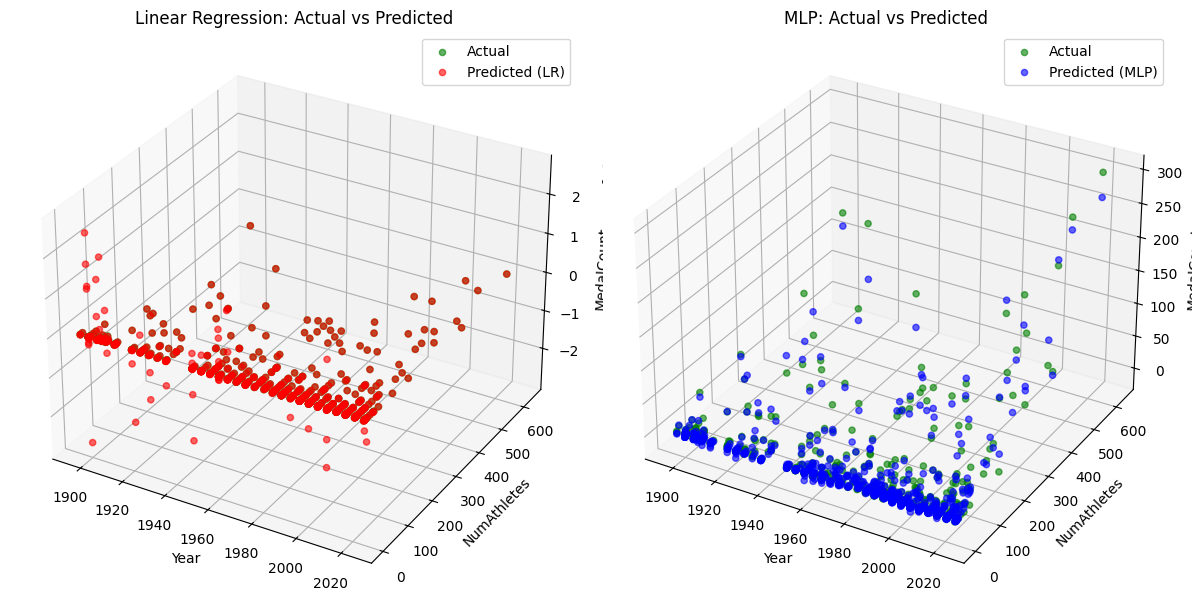

In [16]:
# STEP 7: 3D Plots for Actual vs Predicted
# ----------------------------------------
# We will pick Year and NumAthletes for X and Y axes, and compare actual MedalCount to predictions.

# Inverse transform the numeric features for better interpretability in plots
numeric_data_test = X_test[numeric_feats].copy()
numeric_data_test_inv = scaler.inverse_transform(numeric_data_test)
X_test_unscaled = X_test.copy()
X_test_unscaled[numeric_feats] = numeric_data_test_inv

year_vals = X_test_unscaled['Year']
athlete_vals = X_test_unscaled['NumAthletes']
actual = y_test
pred_lr = y_test_pred_lr
pred_mlp = y_test_pred_mlp

fig = plt.figure(figsize=(12,6))

# Left plot: Linear Regression Actual vs Predicted
ax = fig.add_subplot(121, projection='3d')
ax.scatter(year_vals, athlete_vals, actual, c='green', label='Actual', alpha=0.6)
ax.scatter(year_vals, athlete_vals, pred_lr, c='red', label='Predicted (LR)', alpha=0.6)
ax.set_xlabel('Year')
ax.set_ylabel('NumAthletes')
ax.set_zlabel('MedalCount')
ax.set_title('Linear Regression: Actual vs Predicted')
ax.legend()

# Right plot: MLP Actual vs Predicted
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(year_vals, athlete_vals, actual, c='green', label='Actual', alpha=0.6)
ax2.scatter(year_vals, athlete_vals, pred_mlp, c='blue', label='Predicted (MLP)', alpha=0.6)
ax2.set_xlabel('Year')
ax2.set_ylabel('NumAthletes')
ax2.set_zlabel('MedalCount')
ax2.set_title('MLP: Actual vs Predicted')
ax2.legend()

plt.tight_layout()
plt.show()

In [19]:
# STEP 8: Prediction Function for a Given Team and Year
# -----------------------------------------------------
# This function takes a team name and a year, constructs the feature vector, and predicts the medal count.
# The predicted medals are rounded to the nearest integer.

def predict_medals(team_name, year_value, model):
    # Check if this (Team, Year) pair exists in our aggregated data
    record = country_year_group[(country_year_group['Team'] == team_name) & (country_year_group['Year'] == year_value)]
    if record.empty:
        print(f"No historical data for {team_name} in {year_value}. Cannot directly predict.")
        return None

    # Extract features from the unscaled dataset
    numsports_val = record['NumSports'].values[0]
    numevents_val = record['NumEvents'].values[0]
    numathletes_val = record['NumAthletes'].values[0]

    # Scale the numeric data
    numeric_data = np.array([[year_value, numsports_val, numevents_val, numathletes_val]])
    numeric_data_scaled = scaler.transform(numeric_data)

    # Construct input vector for the model
    input_dict = {col:0 for col in X.columns}
    input_dict['Year'] = numeric_data_scaled[0,0]
    input_dict['NumSports'] = numeric_data_scaled[0,1]
    input_dict['NumEvents'] = numeric_data_scaled[0,2]
    input_dict['NumAthletes'] = numeric_data_scaled[0,3]

    # Set the team dummy
    team_col = f"Team_{team_name}"
    if team_col in input_dict:
        input_dict[team_col] = 1
    else:
        print("Team not found in training data.")
        return None

    input_df = pd.DataFrame([input_dict])
    predicted_medals = model.predict(input_df)[0]
    predicted_medals = int(round(predicted_medals))
    return predicted_medals

# Example: Predict medals for "China" in 2012 using the Linear Regression model
pred_lr_china_2012 = predict_medals("China", 2012, lr)
print("Predicted Medals (LR, China 2012):", pred_lr_china_2012)


Predicted Medals (LR, China 2012): 109


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [18]:
# STEP 9: Breakdown by Medal Type and Sport
# -----------------------------------------
# The model predicts only total medals. We use the historical proportions of gold/silver/bronze and sports
# from the original data frame `df` for that team-year to estimate a breakdown.

def get_breakdown(team_name, year_value, total_medals):
    # Filter the event-level data for that team-year
    historical_records = df[(df['Team'] == team_name) & (df['Year'] == year_value)]
    if historical_records.empty:
        print("No historical records to determine breakdown.")
        return None, None, None, {}

    # Count historical medals of each type
    gold_count = sum(historical_records['Medal'] == 'Gold')
    silver_count = sum(historical_records['Medal'] == 'Silver')
    bronze_count = sum(historical_records['Medal'] == 'Bronze')
    total_hist = gold_count + silver_count + bronze_count

    # If no medals historically, assume equal distribution
    if total_hist > 0:
        gold_frac = gold_count / total_hist
        silver_frac = silver_count / total_hist
        bronze_frac = bronze_count / total_hist
    else:
        gold_frac = silver_frac = bronze_frac = 1/3

    # Calculate predicted breakdown
    pred_gold = int(round(gold_frac * total_medals))
    pred_silver = int(round(silver_frac * total_medals))
    pred_bronze = int(round(bronze_frac * total_medals))

    # Adjust if rounding doesn't sum up correctly
    diff = total_medals - (pred_gold + pred_silver + pred_bronze)
    if diff != 0:
        pred_bronze += diff

    # Calculate sports distribution
    sport_counts = historical_records[historical_records['Medal'].isin(['Gold','Silver','Bronze'])]
    sport_counts = sport_counts.groupby('Sport').size().reset_index(name='Count')
    if not sport_counts.empty and sport_counts['Count'].sum() > 0:
        sport_counts['Fraction'] = sport_counts['Count'] / sport_counts['Count'].sum()
        sport_pred = {}
        for _, row in sport_counts.iterrows():
            sport_pred[row['Sport']] = int(round(row['Fraction'] * total_medals))
        # Adjust for rounding differences
        sport_diff = total_medals - sum(sport_pred.values())
        if sport_diff != 0 and len(sport_pred) > 0:
            first_sport = sport_counts.iloc[0]['Sport']
            sport_pred[first_sport] += sport_diff
    else:
        # If no historical medal by sport, distribute evenly among sports that were participated in.
        participated_sports = historical_records['Sport'].unique()
        if len(participated_sports) > 0:
            even_count = total_medals // len(participated_sports)
            remainder = total_medals % len(participated_sports)
            sport_pred = {sport: even_count for sport in participated_sports}
            # Distribute remainder
            if remainder > 0:
                sports_list = list(sport_pred.keys())
                for i in range(remainder):
                    sport_pred[sports_list[i % len(sports_list)]] += 1
        else:
            # If no sports info, return empty
            sport_pred = {}

    return pred_gold, pred_silver, pred_bronze, sport_pred

# Example breakdown for China 2012 (based on predicted medals):
if pred_lr_china_2012 is not None:
    gold, silver, bronze, sport_dist = get_breakdown("China", 2012, pred_lr_china_2012)
    print(f"Breakdown (LR, China 2012): Gold={gold}, Silver={silver}, Bronze={bronze}")
    print("By Sport:", sport_dist)


Breakdown (LR, China 2012): Gold=47, Silver=35, Bronze=27
By Sport: {'Archery': 1, 'Athletics': 6, 'Badminton': 4, 'Boxing': 3, 'Cycling': 4, 'Diving': 13, 'Fencing': 6, 'Gymnastics': 11, 'Judo': 2, 'Modern Pentathlon': 1, 'Rowing': 2, 'Sailing': 1, 'Shooting': 7, 'Swimming': 14, 'Synchronized Swimming': 10, 'Table Tennis': 9, 'Taekwondo': 3, 'Trampolining': 4, 'Weightlifting': 7, 'Wrestling': 1}
